In [1]:
%reload_ext autoreload
%autoreload 2

# curvature measurement of the path

# import

In [2]:
# imports ------------------------------------------------
from cProfile import label
from collections import deque
from distutils.log import debug
from pathlib import Path
from matplotlib import pyplot as plt

import torch
from plot_ult import *
from numpy import pi
import pickle
# import seaborn as sns
import scipy.stats as stats



In [3]:
import configparser
config = configparser.ConfigParser()
config.read_file(open('privateconfig'))
datafolder=config['Datafolder']['data']
datapathroot=Path(datafolder)

# load data

In [4]:

# load data ------------------------------------------------
datapath=Path(datapathroot/"human/hgroup")
with open(datapath, 'rb') as f:
    hstates, hactions, htasks = pickle.load(f)

datapath=Path(datapathroot/"human/agroup")
with open(datapath, 'rb') as f:
    astates, aactions, atasks = pickle.load(f)
# get the side tasks (stright trials do not have curvature)
res=[]
for task in htasks:
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/5*0.7 or a>=pi/5*0.7:
        res.append(task)
sidetasks=np.array(res)


# helper functions

In [40]:

# curvature defination ------------------------------------------------
def curvature_height(xs,ys):
    # the height of rotated (flatten) path
    end=np.array([xs[-1],ys[-1]])
    rotation=xy2pol(end,rotation=False)[1].item() # the rotated angle
    R=np.array([[np.cos(rotation),np.sin(rotation)],[-np.sin(rotation),np.cos(rotation)]])
    rotatedxy=R@np.vstack([xs,ys])
    height=np.max(rotatedxy[1])
    return height

def curvature_totalangle(a):   
    return float(abs(sum(a[:,1])))

def curvature_math(xs,ys, onevalue=True,debug=False):
    # return the mean abs value of the curvature, given xs and ys
    dx= np.gradient(xs);dy = np.gradient(ys)
    d2x = np.gradient(dx);d2y = np.gradient(dy)
    curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5
    curvature=curvature[~np.isnan(curvature)]
    if not debug:
        curvature=curvature[np.where(abs(np.diff(curvature))<2)]
    if onevalue:
        return np.sum(curvature)/len(curvature)
    return curvature

def curvature_var(xs,ys):
    cur=curvature_math(xs,ys, onevalue=False)
    return np.var(cur)

# wrapper functions 
def curvature_data(states, actions, state_eval=curvature_math, action_eval=None):

    state_cur=[]
    for s in states:
        xs,ys=np.array(s[:,0].T),np.array(s[:,1].T)
        state_cur.append(state_eval(xs,ys))
    res=np.array(state_cur)
    if action_eval:
        action_cur=[]
        for a in actions:
            action_cur.append(action_eval(a))
        res=np.array([state_cur,action_cur])
    return res

def curvature_data_hist(adata,hdata, labels=['ASD','NT'],color=['r','b'],eval=curvature_math):
    # get data
    (astates,aactions,atasks,aindls),(hstates,hactions,htasks,hindls)=adata,hdata
    ares=curvature_data([astates[i] for i in aindls],[aactions[i] for i in aindls], state_eval=eval, action_eval=None)
    hres=curvature_data([hstates[i] for i in aindls],[hactions[i] for i in hindls], state_eval=eval, action_eval=None)
    npsummary(ares)
    npsummary(hres)
    # plot hist
    with initiate_plot(2, 3,300) as fig:
        ax=fig.add_subplot(111)
        ax.bar([1,2],[np.mean(ares),np.mean(hres)], yerr=[np.std(ares)/np.sqrt(len(ares)),np.std(hres)/np.sqrt(len(hres))],color=color)
        ax.set_xticks([1,2])
        ax.set_xticklabels(labels)
        ax.set_ylabel('curvature')
        ax.set_yticks([0,0.5])
        quickspine(ax)
    return ax




# plots

In [34]:
# stats
allares, allhres=[],[]
alldiff=[]
allratio=[]
for ind in range(len(atasks)):
    # for each target, find k targets.
    k=3
    thetask=atasks[ind]
    aindls=similar_trials(ind, atasks,ntrial=k)
    hindls=similar_trials2this(htasks,thetask,ntrial=k)
    # computate curvature
    ares=curvature_data([astates[i] for i in aindls],[aactions[i] for i in aindls], state_eval=curvature_math, action_eval=None)
    hres=curvature_data([hstates[i] for i in aindls],[hactions[i] for i in hindls], state_eval=curvature_math, action_eval=None)
    # add result to alldiff
    allares.append(ares[0]), allhres.append(hres[0])
    # alldiff.append(ares[0]-hres[0])
    alldiff.append(np.mean(ares)-np.mean(hres))
    allratio.append(np.mean(ares)/np.mean(hres))
npsummary(allares), npsummary(allhres), npsummary(alldiff),npsummary(allratio)
print(stats.ttest_1samp(alldiff, 0))
print(stats.ttest_1samp(np.log(allratio), 0))

n samples  2019
mean  0.4459210812928287
std  0.3582176125814719
sem  0.007972210835056864
med  0.3721649944782257
range  0.014319354996961705 6.967528820037842
n samples  2019
mean  0.4295451817053634
std  0.31547618863565174
sem  0.007020991154284947
med  0.36650883067737927
range  0.007974777619043987 6.704896738831426
n samples  2019
mean  0.014890035755496293
std  0.3206157012129374
sem  0.0071353721238868505
med  -0.005679096093784586
range  -2.133407224240522 1.848815455672122
n samples  2019
mean  1.2210884672508395
std  0.948354154739773
sem  0.0211058278609014
med  0.9799991354444688
range  0.0388712225691092 10.152573922143954
TtestResult(statistic=2.0862749079410654, pvalue=0.03707901303911987, df=2018)
TtestResult(statistic=-2.0640776483595378, pvalue=0.039137911920142404, df=2018)


(array([  2.,   1.,   0.,   0.,   0.,   2.,   0.,   0.,   4.,  19.,  23.,
         46.,  43.,  78., 118.,  99., 150., 159., 238., 212., 177., 177.,
        145., 121.,  74.,  58.,  28.,  15.,  10.,  13.,   2.,   1.,   4.]),
 array([-3.24750108, -3.0788578 , -2.91021452, -2.74157123, -2.57292795,
        -2.40428467, -2.23564138, -2.0669981 , -1.89835482, -1.72971153,
        -1.56106825, -1.39242497, -1.22378168, -1.0551384 , -0.88649512,
        -0.71785183, -0.54920855, -0.38056527, -0.21192199, -0.0432787 ,
         0.12536458,  0.29400786,  0.46265115,  0.63129443,  0.79993771,
         0.968581  ,  1.13722428,  1.30586756,  1.47451085,  1.64315413,
         1.81179741,  1.9804407 ,  2.14908398,  2.31772726]),
 <BarContainer object of 33 artists>)

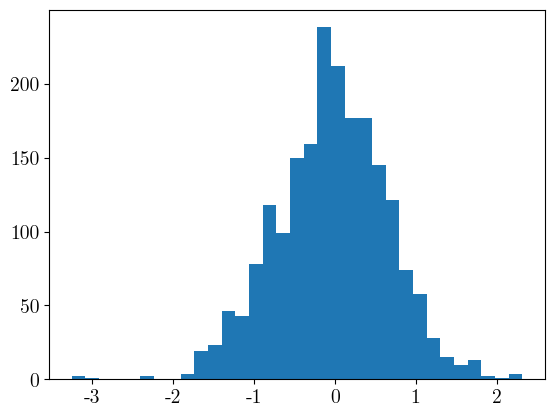

In [33]:
plt.hist(np.log(allratio), bins=33)
allratio

In [37]:
2863-56-10-4555+\
-15+\
-365+\
-2658+\
+30265+\
+11259\
+113+\
604

37445

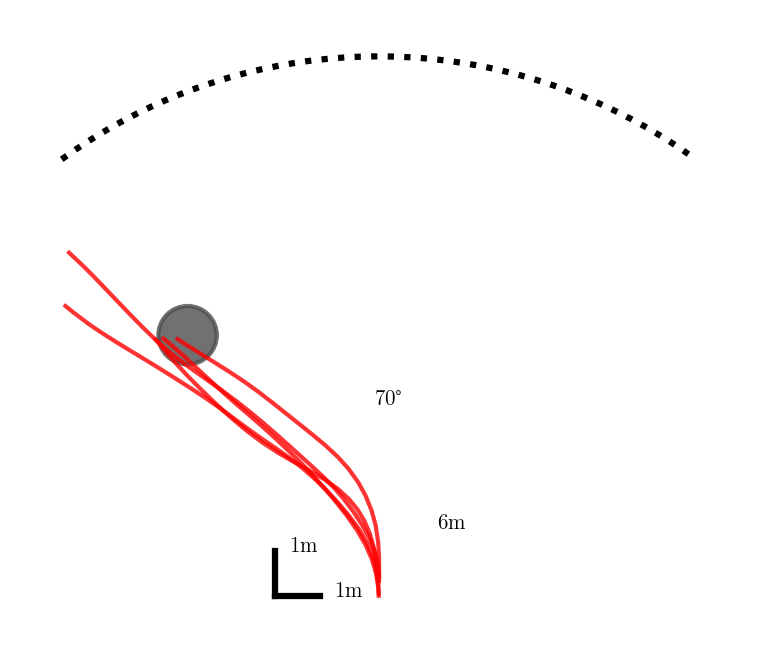

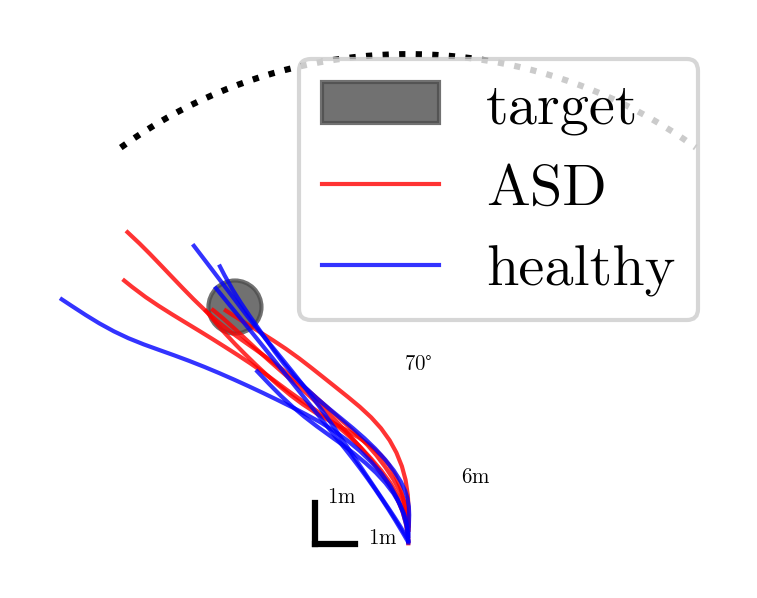

In [38]:
# visualize the path and curvature ---------------------------

# for one given random task
ind=np.random.randint(0,len(atasks))
thetask=atasks[ind]
aindls=similar_trials(ind, atasks,ntrial=5)
hindls=similar_trials2this(htasks,thetask,ntrial=5)

ax=plotoverheadhuman(aindls,astates,atasks,alpha=0.8,fontsize=5,color='r',label='ASD')
ax=plotoverheadhuman(hindls,hstates,htasks,alpha=0.8,fontsize=5,ax=ax,color='b',label='healthy')
handles, labels_ = ax.get_legend_handles_labels()
by_label = dict(zip(labels_, handles))
ax.legend(by_label.values(), by_label.keys(),loc='upper right')
ax.get_figure()


n samples  5
mean  0.6337384659555397
std  0.07412933976018891
sem  0.03315164856619207
med  0.6044005689949825
range  0.5560743897049515 0.7496172587076823
n samples  5
mean  0.4844300387794954
std  0.14822441124621852
sem  0.06628797189428579
med  0.45369516719471326
range  0.30854029655456544 0.7594016393025717


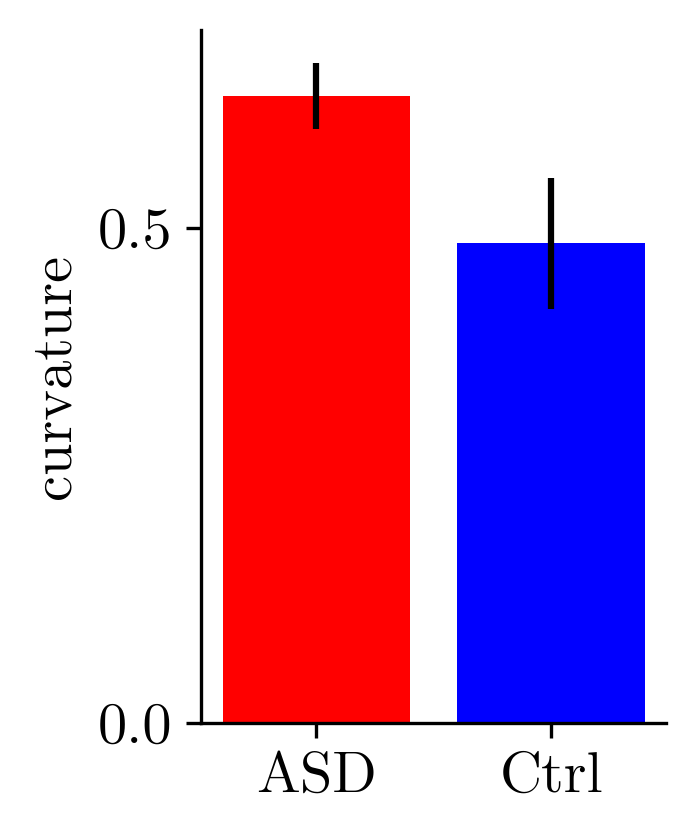

TtestResult(statistic=1.8018535648312373, pvalue=0.10924306172474108, df=8.0)

In [46]:

# use math curvature calculation
ax=curvature_data_hist((astates,aactions,atasks,aindls),(hstates,hactions,htasks,hindls), labels=['ASD','Ctrl'],eval=curvature_math)

# test stats
ares=curvature_data([astates[i] for i in aindls],[aactions[i] for i in aindls], state_eval=curvature_math, action_eval=None)
hres=curvature_data([hstates[i] for i in aindls],[hactions[i] for i in hindls], state_eval=curvature_math, action_eval=None)
stats.ttest_ind(ares, hres)


In [48]:
quicksave('curvature sem',fig=ax.get_figure())

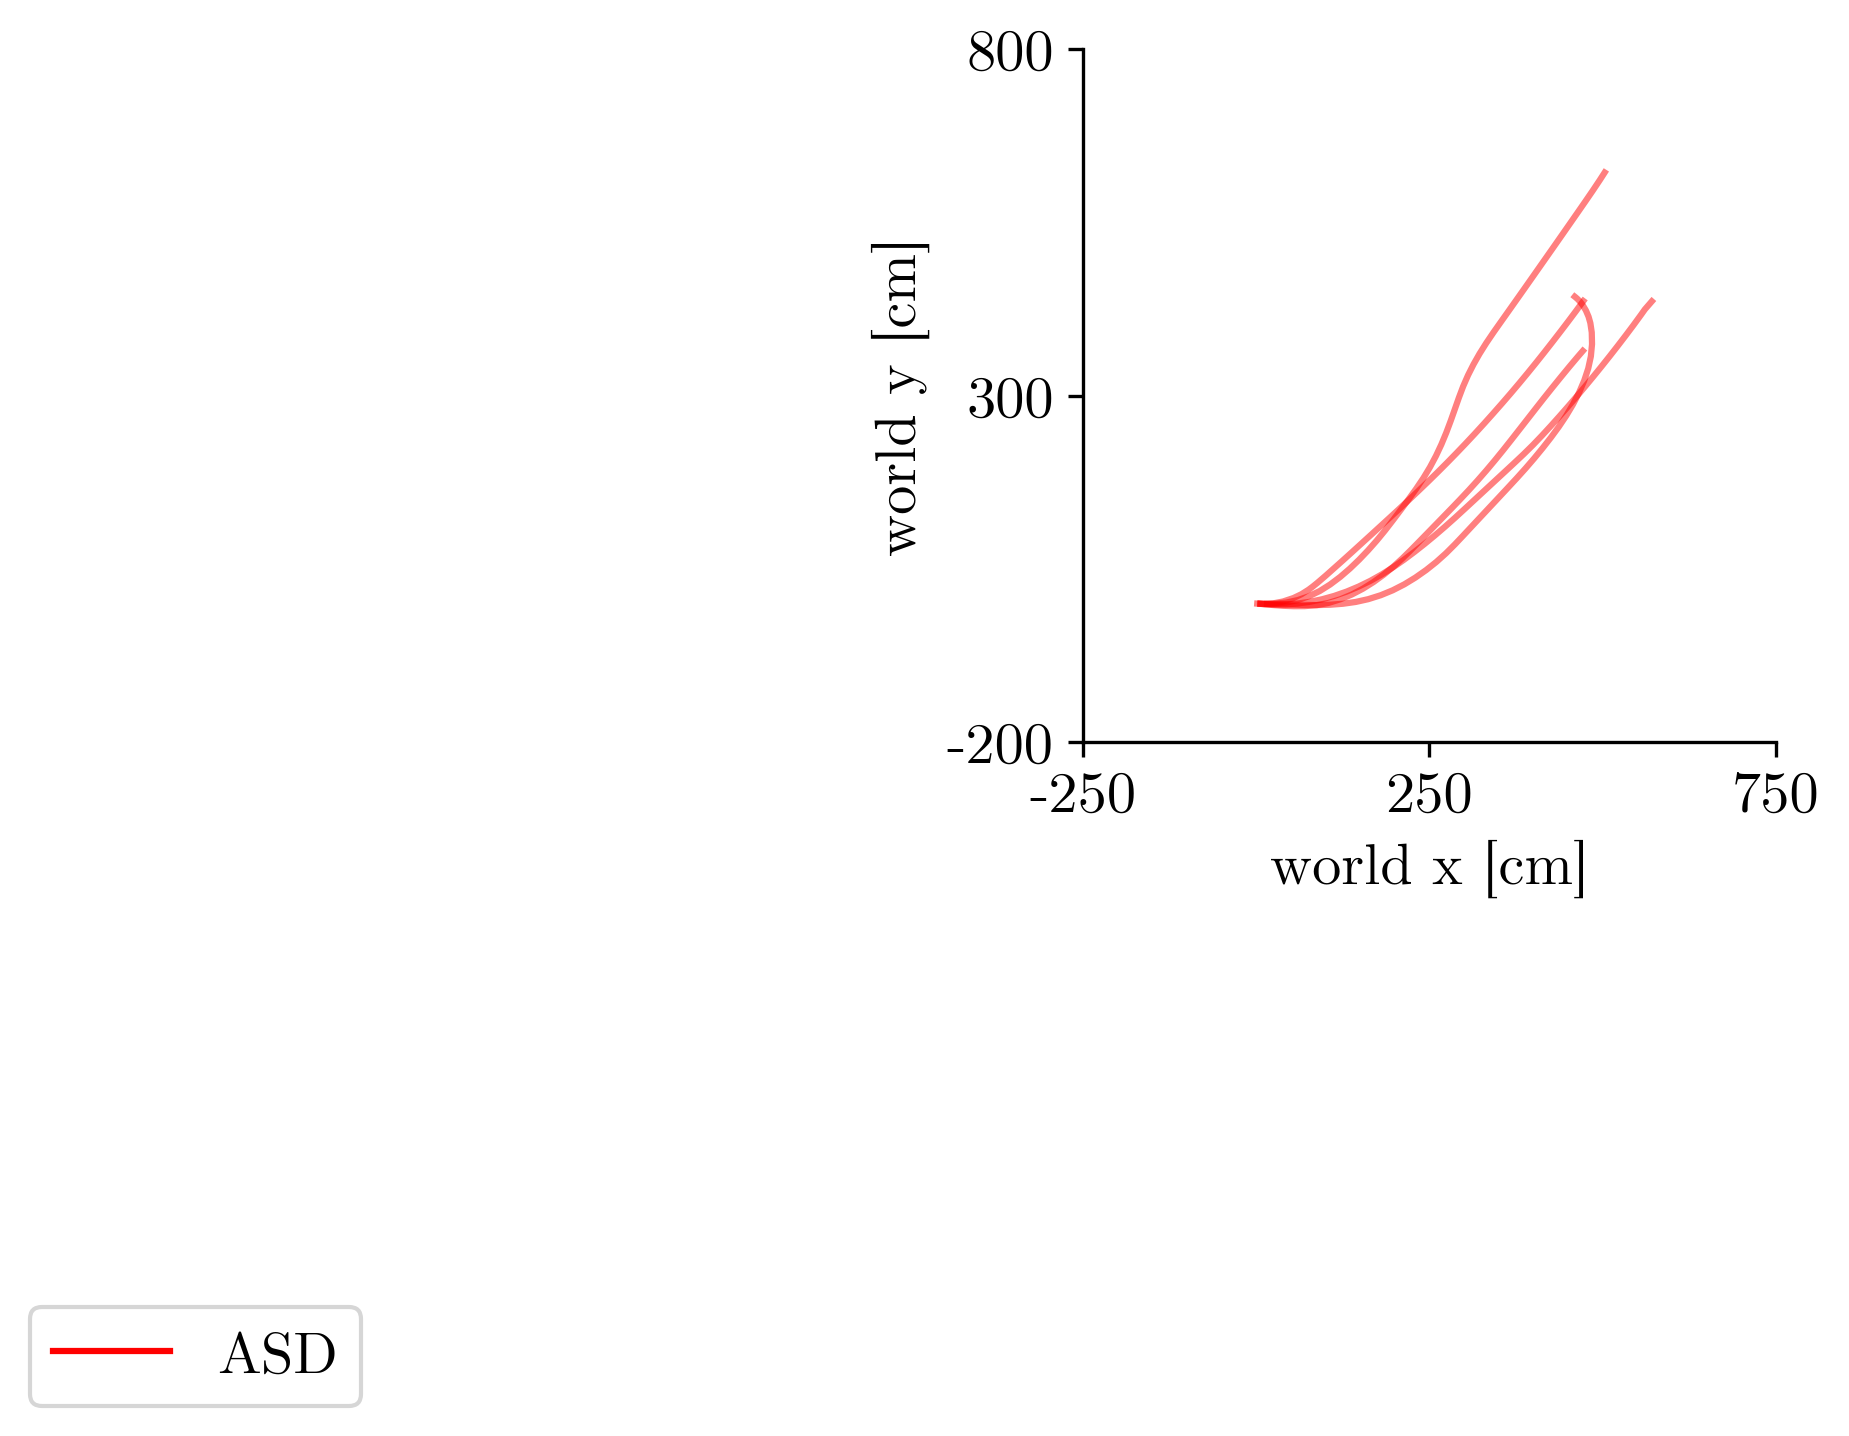

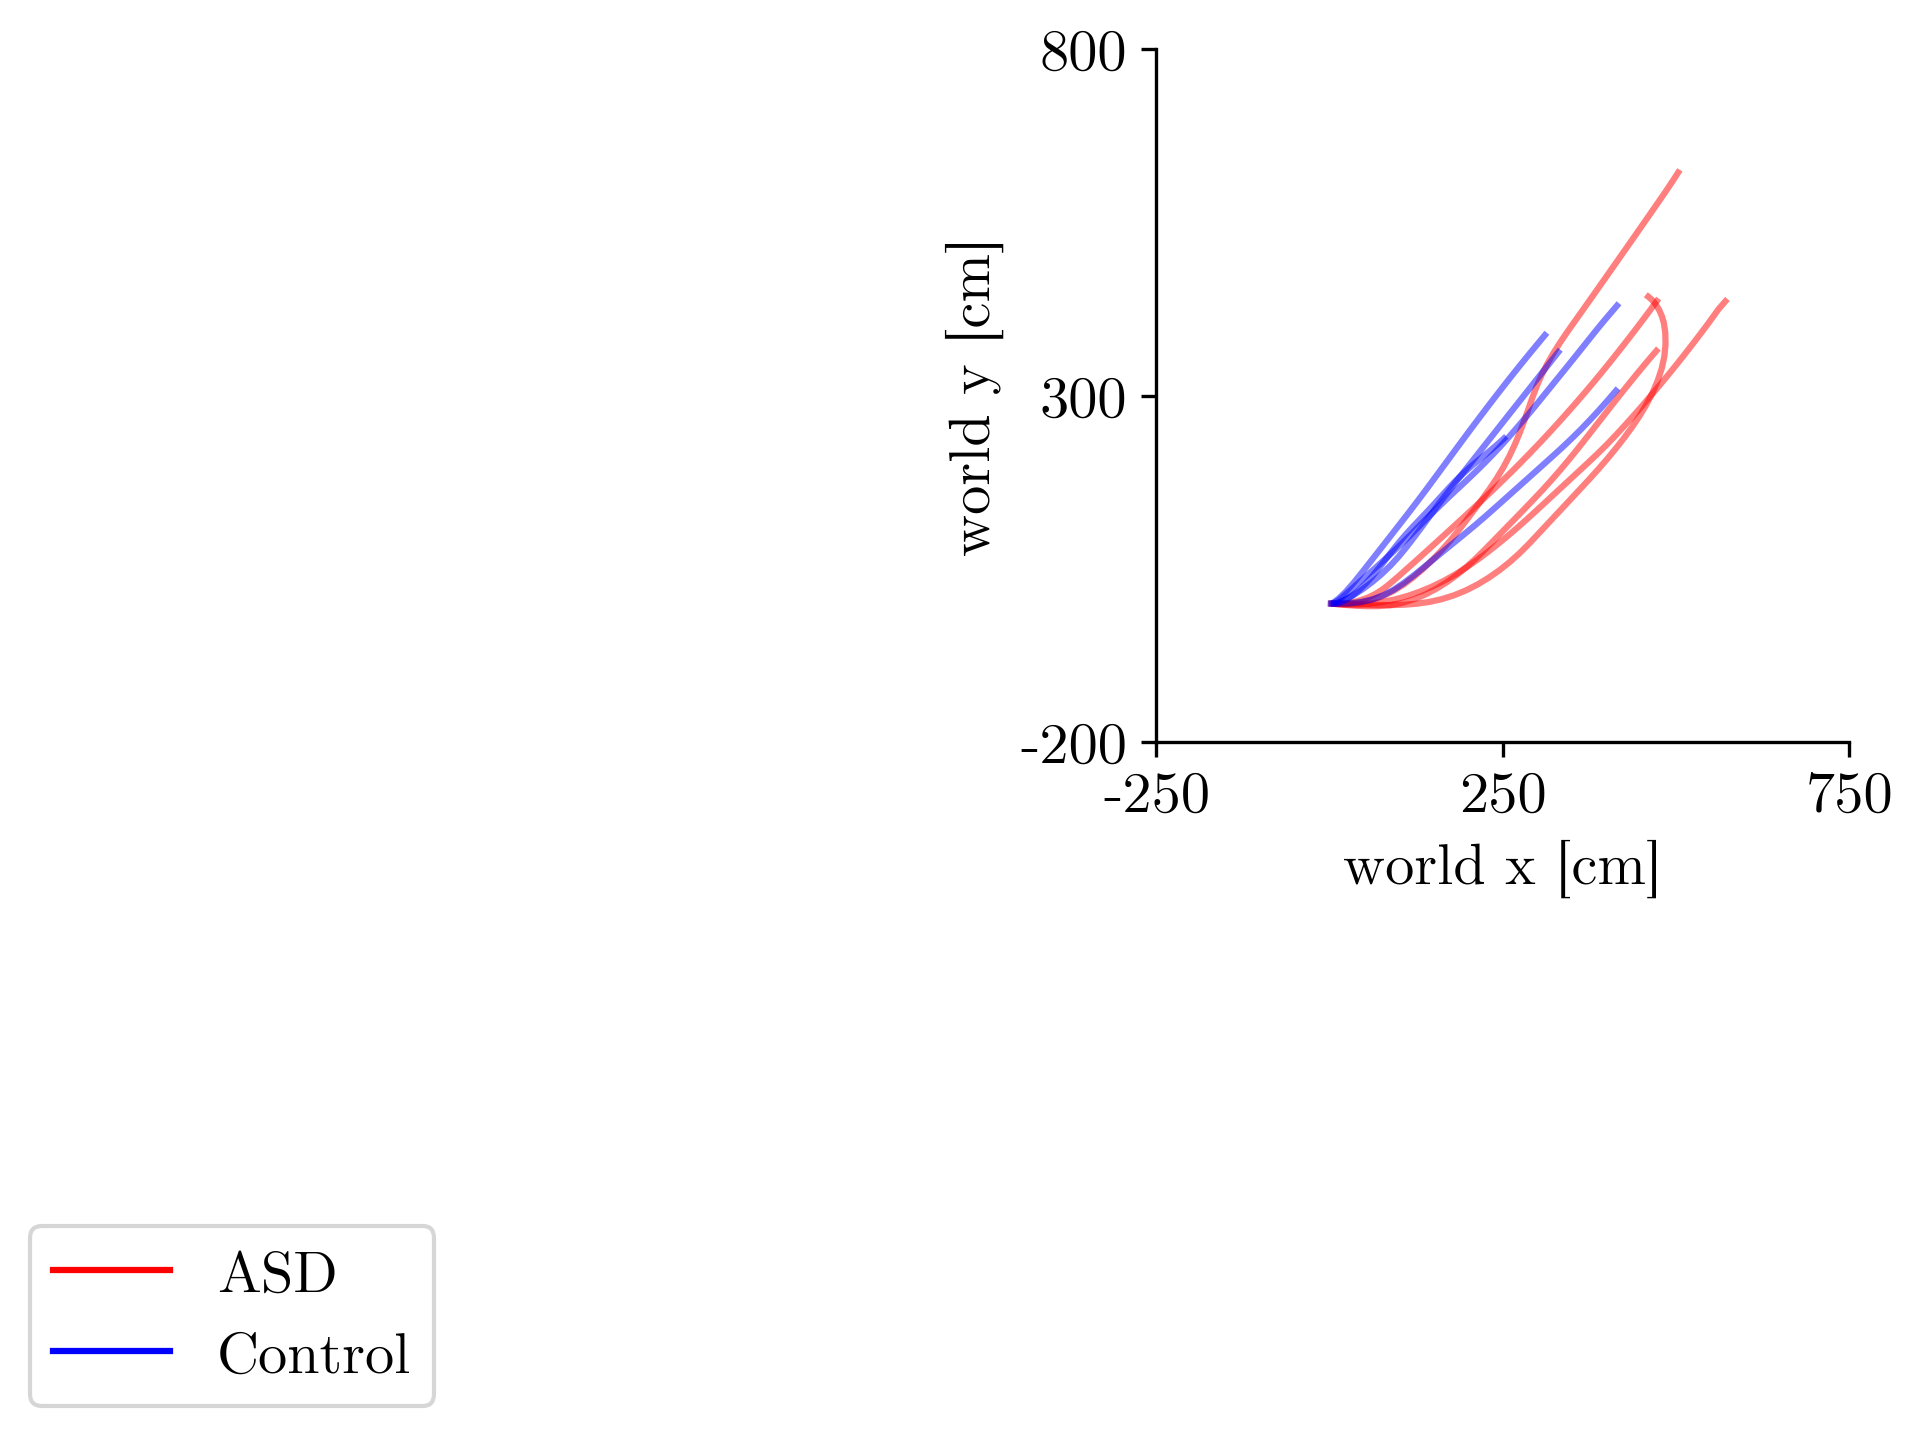

In [28]:

# for one given task
thetask=[2,2]
aindls=similar_trials2this(atasks, thetask,ntrial=5)
hindls=similar_trials2this(htasks,thetask,ntrial=5)
subsetastates=[astates[i] for i in aindls]
# subsetastates=avg_states(subsetastates)
ax=plotoverhead_simple(subsetastates,thetask,color='red',label='ASD')
subsethstates=[hstates[i] for i in hindls]
# subsethstates=avg_states(subsethstates)
plotoverhead_simple(subsethstates,thetask,ax=ax,label='Control')
ax.get_figure()



In [45]:
# for all side tasks stats together

# get the side tasks )
degree=30
ares, hres=[],[]
for ind, task in enumerate(atasks):
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/180*degree or a>=pi/180*degree:
        ares.append(ind)
for ind, task in enumerate(htasks):
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/180*degree or a>=pi/180*degree:
        hres.append(ind)
aindls=np.array(ares)
hindls=np.array(hres)

# test stats
ares=curvature_data([astates[i] for i in aindls],[aactions[i] for i in aindls], state_eval=curvature_math, action_eval=None)
hres=curvature_data([hstates[i] for i in hindls],[hactions[i] for i in hindls], state_eval=curvature_math, action_eval=None)
print(stats.ttest_ind(ares, hres, alternative=
'less'))


TtestResult(statistic=-1.244787466056738, pvalue=0.10671475312707071, df=1328.0)


TtestResult(statistic=-1.3797619111817623, pvalue=0.16790396102247113, df=1264.095429797141)

TtestResult(statistic=0.42441170067786865, pvalue=0.6631043601701336, df=36.0)
n samples  10
mean  0.7270250802146487
std  0.19498507658401895
sem  0.061659695174786366
med  0.6689183464298001
range  0.5169385274251302 1.1347431036142201
n samples  10
mean  0.40418653461243237
std  0.21906012533995506
sem  0.06927289405962249
med  0.33486022082242095
range  0.08993252118428548 0.7458392872529871


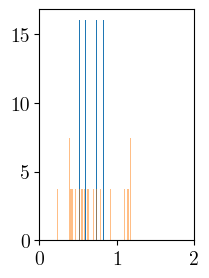

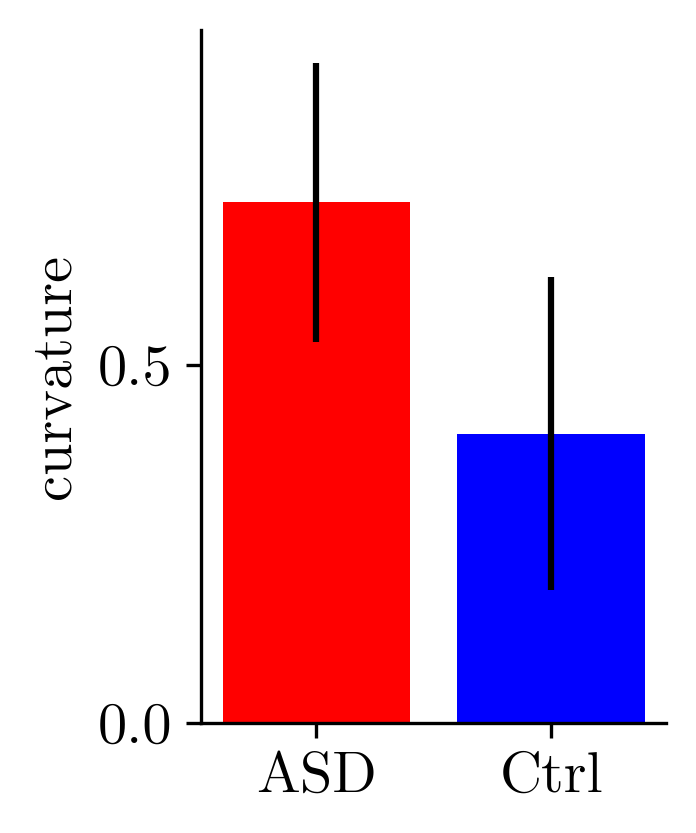

In [31]:
# for all side tasks plot

# get the side tasks )
degree=30
ares, hres=[],[]
for ind, task in enumerate(atasks):
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/180*degree or a>=pi/180*degree:
        ares.append(ind)
for ind, task in enumerate(htasks):
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/180*degree or a>=pi/180*degree:
        hres.append(ind)
aindls=np.array(ares)
hindls=np.array(hres)

# test stats
ares=curvature_data([astates[i] for i in aindls],[aactions[i] for i in aindls], state_eval=curvature_math, action_eval=None)
hres=curvature_data([hstates[i] for i in hindls],[hactions[i] for i in hindls], state_eval=curvature_math, action_eval=None)
print(stats.ttest_ind(ares, hres, alternative=
'less'))

plt.hist(ares, density=True, bins=99)
plt.hist(hres, density=True, bins=99, alpha=0.5)
plt.xlim(0,2)

# plot
ax=curvature_data_hist((astates,aactions,atasks,aindls),(hstates,hactions,htasks,hindls), labels=['ASD','Ctrl'],eval=curvature_math)
# quicksave('side tasks path curvature asd vs nt',fig=ax.get_figure())


In [ ]:

# vary theta and plot curvature -------------------------------------


# states,actions=run_trials(agent, env, phi, theta, task,ntrials=10)
# res=curvature_data(states, actions, state_eval=curvature_math, action_eval=None)

def avg_states(states):
    sharedts=min([len(s) for s in states])
    overlapstates=torch.stack([s[:sharedts] for s in states]) # ith trial, t, state dim
    res=torch.mean(overlapstates, axis=0) # t, state dim
    return res

def curvaturewithmath(theta):
    states,actions=run_trials(agent, env, phi, theta, [0.6,0.6],ntrials=300)
    # statemu=avg_states(states)
    curvature=curvature_data(states, actions, state_eval=curvature_math, action_eval=None)
    curvature=curvature[~np.isnan(curvature)]
    # curvature=curvature_math(statemu[:,0].tolist(),statemu[:,1].tolist())
    return np.mean(curvature)

gridreso=20
dx,dy=np.zeros((11)),np.zeros((11))
dx[5]=1 # noise
dy[8]=1 # cost
X,Y=np.linspace(-0.7,0.7,gridreso), np.linspace(-0.45,0.9,gridreso)
paramls=[]
for i in range(gridreso):
    for j in range(gridreso):
        theta=torch.tensor(dx*X[i]+dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(theta)

Z=[curvaturewithmath(each) for each in paramls]
# with open('curvatureZnoisecost2', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# with open('curvatureZnoisecost2', 'rb') as f:
#     paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T


with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ,origin='lower', extent=(midpoint[5]+X[0],midpoint[5]+X[-1],midpoint[8]+Y[0],midpoint[8]+Y[-1]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    # ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('obs noise')
    ax.set_ylabel('control cost')
    # ax.scatter(truedelta[5]/2,truedelta[8]/2,label='inferred delta') # inferred delta
    # ax.legend()
    quickspine(ax)






In [ ]:

# cost vs acc timing --------------------------------------------------------------
# seems cost affects the timinig
def costacctiming(theta,ntrials=300):
    states,actions=run_trials(agent, env, phi, theta, [0.7,0.3],ntrials=ntrials)
    sharedt=min([len(a)-1 for a in actions])
    sharedw=np.mean(np.array(torch.stack([a[:sharedt,1] for a in actions])),axis=0)
    sharedv=np.mean(np.array(torch.stack([a[:sharedt,0] for a in actions])),axis=0)
    shareds=np.mean(np.array(torch.stack([s[:sharedt,2] for s in states])),axis=0)
    sharedxy=np.mean(np.array(torch.stack([s[:sharedt,:2] for s in states])),axis=0)
    return (sharedv,sharedw,shareds,sharedxy)

gridreso=5
dx,dy=np.zeros((11)),np.zeros((11))
dy[8]=1 # cost
Y=np.linspace(-0.,1.5,gridreso)
paramls=[]
for j in range(gridreso):
    theta=torch.tensor(dy*Y[j]+np.array(phi).reshape(-1)).float().view(-1,1)
    paramls.append(theta)
res=[costacctiming(each) for each in paramls]
mints=min([len(r[0]) for r in res])

resv=[r[0][:mints] for r in res]
with initiate_plot(2,2,300) as f:
    ax=f.add_subplot(111)
    _cmap=sns.color_palette("rocket", n_colors=5)
    for z,c in zip(resv,_cmap):
            ax.plot(z,color=c)
    norm = plt.Normalize(2,0)
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])
    plt.colorbar(sm,label='w control cost')
    plt.xlabel('ts [0.1 s]')
    plt.ylabel('v control [m/s]')
    quickspine(ax)
plt.show()

resw=[r[1][:mints] for r in res]
with initiate_plot(2,2,300) as f:
    ax=f.add_subplot(111)
    _cmap=sns.color_palette("rocket", n_colors=5)
    for z,c in zip(resw,_cmap):
            ax.plot(z,color=c)
    norm = plt.Normalize(2,0)
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])
    plt.colorbar(sm,label='w control cost')
    plt.xlabel('ts [0.1 s]')
    plt.ylabel('w control [90 degree/s]')
    quickspine(ax)
plt.show()

# turned angle within same time
turned_angle=np.array([s[:mints] for _,_,s,_ in res])
with initiate_plot(2,2,300) as f:
    ax=f.add_subplot(111)
    _cmap=sns.color_palette("rocket", n_colors=5)
    for z,c in zip(turned_angle,_cmap):
            ax.plot(z,color=c)
    norm = plt.Normalize(2,0)
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])
    plt.colorbar(sm,label='w control cost')
    plt.xlabel('ts [0.1 s]')
    plt.ylabel('heading direction [rad]')
    quickspine(ax)
plt.show()

# path within same time
xy=np.array([s[:mints] for _,_,_,s in res])
with initiate_plot(2,2,300) as f:
    ax=f.add_subplot(111)
    _cmap=sns.color_palette("rocket", n_colors=5)
    for z,c in zip(xy,_cmap):
            ax.plot(z[:,0]*200,z[:,1]*200,color=c)
            ax.scatter(z[-1,0]*200,z[-1,1]*200,color=c)
    norm = plt.Normalize(2,0)
    sm = plt.cm.ScalarMappable(cmap="rocket", norm=norm)
    sm.set_array([])
    plt.colorbar(sm,label='w control cost')
    ax.set_xlabel('world x [cm]')
    ax.set_ylabel('world y [cm]')
    quickspine(ax)
    ax.axis('equal')
plt.show()




def triallen(theta,ntrials=300):
    states,_=run_trials(agent, env, phi, theta, [0.5,0.5],ntrials=ntrials)
    lens=[len(s) for s in states]
    return lens
res=np.array([triallen(each) for each in paramls])
res=np.array(res)
np.mean(res,axis=1)



formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ,origin='lower', extent=(midpoint[5]+X[0],midpoint[5]+X[-1],midpoint[8]+Y[0],midpoint[8]+Y[-1]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    # ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('noise')
    ax.set_ylabel('cost')
    # ax.scatter(truedelta[5]/2,truedelta[8]/2,label='inferred delta') # inferred delta
    # ax.legend()





# overhead target position and color for curvature ------------------------------------------------
ares=curvature_data(astates, aactions, state_eval=curvature_math, action_eval=None)
validind=np.where(np.array(ares)<2)
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.scatter(atasks[validind,0],atasks[validind,1],c=ares[validind],s=1)
    f.colorbar(im,label='curvature')
    ax.set_xlabel('world x [2 m]')
    ax.set_ylabel('world x [y m]')
    ax.set_title('ASD')

hres=curvature_data(hstates, hactions, state_eval=curvature_math, action_eval=None)
validind=np.where(np.array(hres)<2)
with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.scatter(htasks[validind,0],htasks[validind,1],c=hres[validind],s=1)
    f.colorbar(im,label='curvature')
    ax.set_xlabel('world x [2 m]')
    ax.set_ylabel('world x [y m]')
    ax.set_title('Control')







In [ ]:

# more validations -------------------------------------------------------------

# compare curvature vs curvature var ----------------------------------------------------
'''
ASD seems to have a more constant curvature, while control seems turn then go.
Thus, the variance of curvature might be a better indicator.
'''
xs=np.linspace(0,1,9)
ys=(1-xs**2)**0.5

logxs=np.linspace(0,1,90)
logys=(1-logxs**2)**0.5

f,ax=plt.subplots(2,2,figsize=(6,6),sharey=True)
ax[0,0].scatter(xs,ys)
ax[0,0].set_xlabel('world x')
ax[0,0].set_ylabel('world y')
ax[0,1].scatter(logxs,logys)
ax[0,1].set_xlabel('world x')
ax[1,0].plot(curvature_math(xs,ys,onevalue=False))
ax[1,0].set_xlabel('ts')
ax[1,0].set_ylabel('curvature')
ax[1,0].text(1,2,s='curvature mean is {:.3f}'.format(curvature_math(xs,ys)))
ax[1,0].text(1,1,s='curvature var is {:.3f}'.format(curvature_var(xs,ys)))
ax[1,1].plot(curvature_math(logxs,logys,onevalue=False))
ax[1,1].text(1,2,s='curvature mean is {:.3f}'.format(curvature_math(logxs,logys)))
ax[1,1].text(1,1,s='curvature var is {:.3f}'.format(curvature_var(logxs,logys)))
ax[1,1].set_xlabel('ts')
plt.tight_layout()

# curvature_var(xs,ys)
# curvature_var(logxs,logys)
# curvature_math(xs,ys)
# curvature_math(logxs,logys)
# plt.plot(curvature_math(xs,ys,onevalue=False))
# plt.plot(curvature_math(logxs,logys,onevalue=False))



# if throwed outliers of the same type, for both group ----------------------------------------------------

# ind=np.random.randint(0,len(atasks))
# thetask=atasks[ind]
# aindls=similar_trials(ind, atasks,ntrial=5)
# hindls=similar_trials2this(htasks,thetask,ntrial=5)

# ax=plotoverheadhuman(aindls,astates,atasks,alpha=0.8,fontsize=5,color='r',label='ASD')
# ax=plotoverheadhuman(hindls,hstates,htasks,alpha=0.8,fontsize=5,ax=ax,color='b',label='healthy')
# handles, labels_ = ax.get_legend_handles_labels()
# by_label = dict(zip(labels_, handles))
# ax.legend(by_label.values(), by_label.keys(),loc='upper right')
# ax.get_figure()

# curvature_data_hist((astates,aactions,atasks,aindls),(hstates,hactions,htasks,hindls), labels=['ASD','Ctrl'],eval=curvature_math)
# curvature_data_hist((astates,aactions,atasks,aindls),(hstates,hactions,htasks,hindls), labels=['ASD','Ctrl'],eval=curvature_var)


ares=curvature_data(astates, aactions, state_eval=curvature_math, action_eval=None)
invalidind=np.where(np.array(ares)>2)

for i in invalidind[0]:  

    with initiate_plot(9,3,300) as f:
        # overhead
        ax=f.add_subplot(131)
        xs,ys=np.array(astates[i][:,0]),np.array(astates[i][:,1])
        ax.scatter(atasks[i,0],atasks[i,1])
        cur=curvature_math(xs,ys,onevalue=False,debug=True)
        colorgrad_line(xs,ys,cur,ax=ax)
        ax.set_ylim(-2,2)
        ax.set_xlim(0,4)
        ax.axis('equal')
        ax.set_ylabel('world y [2m]')
        ax.set_xlabel('world x [2m]')
        f.axes[-1].set_ylabel('curvature')
        ax=f.add_subplot(132)
        ax.plot(aactions[i])
        ax.set_ylabel('control')
        ax.set_xlabel('ts')
        ax.set_ylim(-1,1)
        ax.hlines(0,0,len(xs),'k',linewidth=5,alpha=0.5)
        ax2 = ax.twinx()
        ax2.plot(cur,color='g',label='curvature')
        ax2.set_ylabel('curvature')
        plt.legend()
        plt.tight_layout()


hres=curvature_data(hstates, hactions, state_eval=curvature_math, action_eval=None)
invalidind=np.where(np.array(hres)>2)

for i in invalidind[0]:  

    with initiate_plot(9,3,300) as f:
        # overhead
        ax=f.add_subplot(131)
        xs,ys=np.array(hstates[i][:,0]),np.array(hstates[i][:,1])
        ax.scatter(htasks[i,0],htasks[i,1])
        cur=curvature_math(xs,ys,onevalue=False,debug=True)
        colorgrad_line(xs,ys,cur,ax=ax)
        ax.set_ylim(-2,2)
        ax.set_xlim(0,4)
        ax.axis('equal')
        ax.set_ylabel('world y [2m]')
        ax.set_xlabel('world x [2m]')
        f.axes[-1].set_ylabel('curvature')
        ax=f.add_subplot(132)
        ax.plot(hactions[i])
        ax.set_ylabel('control')
        ax.set_xlabel('ts')
        ax.set_ylim(-1,1)
        ax.hlines(0,0,len(xs),'k',linewidth=5,alpha=0.5)
        ax2 = ax.twinx()
        ax2.plot(cur,color='g',label='curvature')
        ax2.set_ylabel('curvature')
        plt.legend()
        plt.tight_layout()




In [ ]:

# other curvature methods tests -------------------------------------------------

# using state, basic curvature 

end=astates[ind][-1][:2]
rotation=xy2pol(end,rotation=False)[1].item()
R=np.array([[np.cos(rotation),np.sin(rotation)],[-np.sin(rotation),np.cos(rotation)]])
rotatedxy=R@np.array(astates[ind][:,:2].T)


def eval_curvature2(agent, env, phi, theta, tasks,ntrials=10):
    costs=[]
    states=[]
    with suppress():
        for task in tasks:
            while len(states)<ntrials:
                env.reset(phi=phi, theta=theta, goal_position=task, pro_traj=None,vctrl=0.,wctrl=0. )
                _,_,_,epstates=run_trial(agent,env,given_action=None, given_state=None, action_noise=0.1)
                if len(epstates)>5:
                    states.append(torch.stack(epstates)[:,:,0])
    for s in states:
        end=s[-1][:2]
        rotation=xy2pol(end,rotation=False)[1].item()
        R=np.array([[np.cos(rotation),np.sin(rotation)],[-np.sin(rotation),np.cos(rotation)]])
        rotatedxy=R@np.array(astates[i][:,:2].T)
        epcost=np.max(rotatedxy[1])
        costs.append(epcost)    
    return sum(costs)


# example rotated curve.
plt.plot(astates[ind][:,0],astates[ind][:,1])
plt.plot(rotatedxy[0],rotatedxy[1])
plt.axis('equal')


#calculation of curvature from the typical formula
ind+=1
from scipy.interpolate import interp1d
fx = interp1d(list(range(len(astates[ind][:,1]))), np.array(astates[ind][:,0]), kind='cubic')
fy = interp1d(list(range(len(astates[ind][:,1]))), np.array(astates[ind][:,1]), kind='cubic')
fa = interp1d(list(range(len(astates[ind][:,1]))), np.array(aactions[ind][:,0]), kind='cubic')

# f2 = interp1d(np.array(astates[ind][:,0]), np.array(astates[ind][:,1]), kind='cubic')

ts=np.linspace(0,len(astates[ind][:,1])-1,100)
plt.plot(fx(ts),fy(ts))
plt.show()

aa=fa(ts)
# plt.plot(aa)

#first derivatives 
dx= np.gradient(fx(ts))
dy = np.gradient(fy(ts))

#second derivatives 
d2x = np.gradient(dx)
d2y = np.gradient(dy)

curvature = np.abs(dx * d2y - d2x * dy) / (dx * dx + dy * dy)**1.5

# testing if removing sudden jumps helps.
plt.plot(
    curvature[np.where((np.abs(np.diff(curvature))<2) & ((aa[1:])>0.2))]
)



# total angle turned / target angle
def eval_extraturning(actions, tasks):
    res=[]
    for a, t in zip(actions,tasks):
        target_angle=xy2pol(t,rotation=False)[1]
        if target_angle<=-pi/5*0.7 or target_angle>=pi/5*0.7:
            res.append(sum(a[:,1])*0.1/xy2pol(t,rotation=False)[1])
    return res

a=eval_extraturning(aactions, atasks)
h=eval_extraturning(hactions, htasks)
plt.hist(a,bins=30)
plt.hist(h,bins=30)


ind+=1
(sum(aactions[ind][:,1]))*0.1/xy2pol(atasks[ind],rotation=False)[1]

ind+=1
(sum(hactions[ind][:,1]))*0.1/xy2pol(htasks[ind],rotation=False)[1]

plt.plot(aactions[0][:,0]/aactions[0][:,1])



plt.plot(a[3][0])

np.arctan2(atasks[0,0],atasks[0,1])
np.arctan2(atasks[2,0],atasks[2,1])
sum([sum(aa[0][:,1])/xy2pol(tt, rotation=False)[1] for aa,tt in zip(a,atasks)])
sum([sum(aa[0][:,1])/xy2pol(tt, rotation=False)[1] for aa,tt in zip(b,atasks)])


sum([sum(aa[:,1]) for aa in aactions])/len(aactions)
sum([sum(aa[:,1]) for aa in hactions])/len(hactions)



sum([sum(aa[:,1])/xy2pol(tt, rotation=False)[1] for aa,tt in zip(aactions,atasks)])
sum([sum(aa[:,1])/xy2pol(tt, rotation=False)[1] for aa,tt in zip(hactions,htasks)])


([sum(aa[:,1])/xy2pol(tt, rotation=False)[1] for aa,tt in zip(aactions,atasks)])

ind=0
ind+=1
tt=atasks[ind]
xy2pol(tt, rotation=False)[1]

aa=aactions[ind]
sum(aa[:,1])

sum(aa[:,1])/xy2pol(tt, rotation=False)[1]




def eval_curvature(agent, env, phi, theta_init, theta_final,tasks,vctrl=0.,wctrl=0.,ntrials=10):
    actions1, actions2=[],[]
    with suppress():
        for task in tasks:
            for _ in range(ntrials):
                env.reset(phi=phi, theta=theta_init, pro_traj=None,vctrl=0.,wctrl=0. )
                epactions,_,_,epstates=run_trial(agent,env,given_action=None, given_state=None, action_noise=0.1)
                if len(epactions)>5:
                    actions1.append(torch.stack(epactions))
        for task in tasks:
            for _ in range(ntrials):
                env.reset(phi=phi, theta=theta_final, pro_traj=None,vctrl=0.,wctrl=0. )
                epactions,_,_,epstates=run_trial(agent,env,given_action=None, given_state=None, action_noise=0.1)
                if len(epactions)>5:
                    actions2.append(torch.stack(epactions))
    cur1=abs(sum([sum(a[:,1]) for a in actions1]))
    cur2=abs(sum([sum(a[:,1]) for a in actions2]))
    return cur2-cur1, cur1, cur2


def curvature(agent, env, phi, theta_init, theta_final,nplots=3,etask=[0.7,-0.3],initv=0.,initw=0.,mkactions=None, pert=None,ntrials=10):

    def sample_trials(agent, env, theta, phi, thistask, initv=0.,initw=0., action_noise=0.1,pert=None,samples=5):
        agent_actions=[]
        agent_beliefs=[]
        agent_covs=[]
        agent_states=[]
        for _ in range(samples):
            with torch.no_grad():
                env.reset(phi=phi,theta=theta,goal_position=thistask,vctrl=initv, wctrl=initw)
                if pert is None:
                    env.obs_traj= np.vstack([np.array([0,0]),np.random.normal(0,1,size=(env.episode_len,2))*np.asfarray(theta[4:6]).T,np.zeros(shape=(20,2))])
                else:
                    env.obs_traj= np.vstack([np.array([0,0]),np.random.normal(0,1,size=(pert))*np.asfarray(theta[4:6]).T + pert,np.zeros(shape=(20,2))])
                epbliefs=[]
                epbcov=[]
                epactions=[]
                epstates=[]
                done=False
                while not done:
                    action = agent(env.decision_info)[0]
                    noise=torch.normal(torch.zeros(2),action_noise)
                    _action=(action+noise).clamp(-1,1)
                    _,_,done,_=env.step(_action) 
                    epactions.append(action)
                    epbliefs.append(env.b)
                    epbcov.append(env.P)
                    epstates.append(env.s)
                agent_actions.append(torch.stack(epactions))
                agent_beliefs.append(torch.stack(epbliefs))
                agent_covs.append(epbcov)
                agent_states.append(torch.stack(epstates))
            estate=torch.stack(agent_states)[0,:,:,0].t()
            return_dict={
            'agent_actions':agent_actions,
            'agent_beliefs':agent_beliefs,
            'agent_covs':agent_covs,
            'estate':estate,
            # 'eaction':eaction,
            'etask':thistask,
            'theta':theta,
        }
        return return_dict

    allactions=[]
    for i in range(ntrials):
        with suppress():
            data=sample_trials(agent, env, theta_init, phi, etask,initv=initv,initw=initw,pert=pert)

            data['agent_actions']

        estate=data['estate']
        agent_beliefs=data['agent_beliefs']
        agent_actions=data['agent_actions']
        allactions.append(data['agent_actions'])

    allactions2=[]
    for i in range(ntrials):
        with suppress():
            data=sample_trials(agent, env, theta_final, phi, etask,initv=initv,initw=initw,pert=pert)
        estate=data['estate']
        agent_beliefs=data['agent_beliefs']
        agent_actions=data['agent_actions']
        allactions2.append(data['agent_actions'])

    return allactions,allactions2


    delta=(theta_final-theta_init)/(nplots-1)

    with initiate_plot(3*nplots, 3,300) as fig:
        subplotmap={}
        for n in range(nplots):
            subplotmap[n]=fig.add_subplot(1,nplots,n+1)

        for n in range(nplots):

            theta=n*delta+theta_init
            theta=torch.clamp(theta, 1e-3)

            for i in range(ntrials):
                with suppress():
                    data=sample_trials(agent, env, theta, phi, etask,initv=initv,initw=initw,pert=pert)
                estate=data['estate']
                agent_beliefs=data['agent_beliefs']
                agent_actions=data['agent_actions']
                
                # overhead
                ax = subplotmap[n]
                ax.plot(estate[0,:]*200,estate[1,:]*200, color=color_settings['s'],alpha=0.5)
                ax.scatter(estate[0,-1]*200,estate[1,-1]*200, color=color_settings['a'],alpha=0.5)
                if i==0:
                    goalcircle = plt.Circle((etask[0]*200,etask[1]*200), 65, color=color_settings['goal'], edgecolor='none', alpha=0.3, linewidth=0.8)
                    ax.add_patch(goalcircle)
                    ax.set_aspect('equal')
                    ax.set_xlabel('world x [cm]')
                    ax.set_ylabel('world y [cm]')
                    ax.spines['top'].set_visible(False)
                    ax.spines['right'].set_visible(False)

                for t in range(len(agent_beliefs[0][:,:,0])):
                    cov=data['agent_covs'][0][t][:2,:2]*200*200
                    pos=  [agent_beliefs[0][:,:,0][t,0]*200,
                            agent_beliefs[0][:,:,0][t,1]*200]
                    plot_cov_ellipse(cov, pos, nstd=3, color=color_settings['b'], ax=ax,alpha=0.05)
                if n!=0:
                    ax.set_yticklabels([])
                    # ax.set_xticklabels([])
                    # ax.set_xlabel('')
                    ax.set_ylabel('')
                ax.set_xticks([]); ax.set_yticks([])
        
            ax.set_xticks(mytick(ax.get_xlim(),3,-1))
            ax.set_yticks(mytick(ax.get_ylim(),3,-1))
            plt.tight_layout()




In [ ]:

# using total angle turned---------------------------------------------------

res=[]
for task in htasks:
    d,a=xy2pol(task, rotation=False)
    # if  env.min_angle/2<=a<env.max_angle/2:
    if a<=-pi/5*0.7 or a>=pi/5*0.7:
        res.append(task)
sidetasks=np.array(res)

sidetasks=sidetasks[:100]


def getcur(x):
    x.clamp_(1e-3,3)
    with torch.no_grad():
        curvature=eval_curvature(agent, env, phi, x,sidetasks,vctrl=0.,wctrl=0.,ntrials=50)
        return  curvature

dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 
dy[7]=1 

X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        theta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(theta)

# Z=ray.get([getcur.remote(each) for each in paramls])

# with open('distinguishparamZvwcostcurvaturesingle', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)

# vary v and w cost, heatmap of curvature
with open('distinguishparamZvwcostcurvaturesingle', 'rb+') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0]+midpoint[8],X[-1]+midpoint[8],Y[0]+midpoint[7],Y[-1]+midpoint[7]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta w cost')
    ax.set_ylabel('delta v cost')
    # ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()



In [ ]:

# using curvature 2, the furthest point -----------------------------------------------------
def eval_curvature2(agent, env, phi, theta, tasks,ntrials=10):
    costs=[]
    states=[]
    with suppress():
        for task in tasks:
            while len(states)<ntrials:
                env.reset(phi=phi, theta=theta, goal_position=task, pro_traj=None,vctrl=0.,wctrl=0. )
                _,_,_,epstates=run_trial(agent,env,given_action=None, given_state=None, action_noise=0.1)
                if len(epstates)>5:
                    states.append(torch.stack(epstates)[:,:,0])
    for s in states:
        end=s[-1][:2]
        rotation=xy2pol(end,rotation=False)[1].item()
        R=np.array([[np.cos(rotation),np.sin(rotation)],[-np.sin(rotation),np.cos(rotation)]])
        rotatedxy=R@np.array(astates[i][:,:2].T)
        epcost=np.max(rotatedxy[1])
        costs.append(epcost)    
    return sum(costs)


def getcur(x):
    x.clamp_(1e-3,3)
    with torch.no_grad():
        curvature=eval_curvature2(agent, env, phi, theta, [None]*50, ntrials=50)
        return  curvature

dx,dy=np.zeros((11)),np.zeros((11))
dx[8]=1 
dy[7]=1 

X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)
paramls=[]
# Z=np.zeros((gridreso,gridreso))
for i in range(gridreso):
    for j in range(gridreso):
        theta=torch.tensor(-dx*X[i]-dy*Y[j]+midpoint).float().view(-1,1)
        paramls.append(theta)

# Z=ray.get([getcur.remote(each) for each in paramls])

# with open('distinguishparamZvwcostcurvature2', 'wb+') as f:
#         pickle.dump((paramls,Z), f, protocol=pickle.HIGHEST_PROTOCOL)



# vary v and w cost, heatmap of curvature
with open('distinguishparamZvwcostcurvature2', 'rb+') as f:
    paramls,Z= pickle.load(f)
formatedZ=np.array(Z).reshape(int(len(Z)**0.5),int(len(Z)**0.5)).T
X,Y=np.linspace(-0.45,1,gridreso), np.linspace(-1.1,0.4,gridreso)

with initiate_plot(3,3,300) as f:
    ax=f.add_subplot(111)
    im=ax.imshow(formatedZ[:,2:],origin='lower', extent=(X[0]+midpoint[8],X[-1]+midpoint[8],Y[0]+midpoint[7],Y[-1]+midpoint[7]),aspect='auto')
    plt.colorbar(im,label='curvature') 
    ax.scatter(0,0,label='zero') # midpoint, 0,0
    ax.set_xlabel('delta w cost')
    ax.set_ylabel('delta v cost')
    # ax.scatter(truedelta[5]/2,truedelta[3]/2,label='inferred delta') # inferred delta
    # ax.legend()
